### Importing packages and data_utils.py

In [1]:
from climsim_utils.data_utils import *

2024-01-11 23:54:07.996403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 23:54:27.010805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Instantiate class

In [2]:
grid_path = '/ocean/projects/atm200007p/jlin96/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/ClimSim/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info,
                  input_mean = input_mean,
                  input_max = input_max,
                  input_min = input_min,
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

### Load scoring data

In [3]:
data.model_names = ['HSR', 'RPN', 'cVAE']

scoring_input_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy"
scoring_target_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy"

# path to target input
data.input_scoring = np.load(scoring_input_path)

# path to target output
data.target_scoring = np.load(scoring_target_path)

data.set_pressure_grid(data_split = 'scoring')

data.reweight_target(data_split = 'scoring')

### Load samples

In [4]:
cvae_samples_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/shared_folder/final_metrics/predictions/cVAE/cvae_samples_manual.h5'
hsr_samples_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/crps_ingredients/hsr_samples_bestcrps.h5'
rpn_samples_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/crps_ingredients/RPN_crps_32_samples.npy'

cvae_color = '#D55E00'
hsr_color = '#E69F00'
rpn_color = '#009E73'

In [5]:
hsr_samples = data_utils.load_h5_file(hsr_samples_path)
hsr_samples = np.expand_dims(data.output_weighting(hsr_samples[:,:,0], data_split = 'scoring', just_weights = True), axis = -1) * hsr_samples

In [25]:
hsr_samples.shape

(1681920, 128, 32)

In [6]:
rpn_samples = data_utils.load_npy_file(rpn_samples_path)
rpn_samples = np.expand_dims(data.output_weighting(rpn_samples[:,:,0], data_split = 'scoring', just_weights = True), axis = -1) * rpn_samples

In [26]:
rpn_samples.shape

(1681920, 128, 32)

In [7]:
cvae_samples = (data_utils.load_h5_file(cvae_samples_path))[:,:,:32]
cvae_samples = np.expand_dims(data.output_weighting(cvae_samples[:,:,0], data_split = 'scoring', just_weights = True), axis = -1) * cvae_samples

In [27]:
cvae_samples.shape

(1681920, 128, 32)

### Define useful functions

In [8]:
num_samples = 1681920

def reshape_output(output, var):
    if var == 'ptend_t':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon, 60))
    elif var == 'ptend_q0001':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon, 60))
    elif var == 'netsw':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'flwds':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'precsc':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'precc':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'sols':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'soll':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'solsd':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'solld':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    return ans

def reshape_samplepreds(samplepreds, var, num_crps):
    if var == 'ptend_t':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,:60,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'ptend_q0001':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,60:120,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'netsw':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,120,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'flwds':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,121,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'precsc':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,122,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'precc':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,123,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'sols':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,124,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'soll':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,125,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'solsd':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,126,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'solld':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,127,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    return ans

### Calculate CRPS

In [9]:
hsr_ptend_t_samples = reshape_samplepreds(hsr_samples, 'ptend_t', 32)
hsr_ptend_q0001_samples = reshape_samplepreds(hsr_samples, 'ptend_q0001', 32)
hsr_netsw_samples = reshape_samplepreds(hsr_samples, 'netsw', 32)
hsr_flwds_samples = reshape_samplepreds(hsr_samples, 'flwds', 32)
hsr_precsc_samples = reshape_samplepreds(hsr_samples, 'precsc', 32)
hsr_precc_samples = reshape_samplepreds(hsr_samples, 'precc', 32)
hsr_sols_samples = reshape_samplepreds(hsr_samples, 'sols', 32)
hsr_soll_samples = reshape_samplepreds(hsr_samples, 'soll', 32)
hsr_solsd_samples = reshape_samplepreds(hsr_samples, 'solsd', 32)
hsr_solld_samples = reshape_samplepreds(hsr_samples, 'solld', 32)

hsr_ptend_t_CRPS = data.calc_CRPS(hsr_ptend_t_samples, data.target_weighted_scoring['ptend_t'])
hsr_ptend_q0001_CRPS = data.calc_CRPS(hsr_ptend_q0001_samples, data.target_weighted_scoring['ptend_q0001'])
hsr_netsw_CRPS = data.calc_CRPS(hsr_netsw_samples, data.target_weighted_scoring['cam_out_NETSW'])
hsr_flwds_CRPS = data.calc_CRPS(hsr_flwds_samples, data.target_weighted_scoring['cam_out_FLWDS'])
hsr_precsc_CRPS = data.calc_CRPS(hsr_precsc_samples, data.target_weighted_scoring['cam_out_PRECSC'])
hsr_precc_CRPS = data.calc_CRPS(hsr_precc_samples, data.target_weighted_scoring['cam_out_PRECC'])
hsr_sols_CRPS = data.calc_CRPS(hsr_sols_samples, data.target_weighted_scoring['cam_out_SOLS'])
hsr_soll_CRPS = data.calc_CRPS(hsr_soll_samples, data.target_weighted_scoring['cam_out_SOLL'])
hsr_solsd_CRPS = data.calc_CRPS(hsr_solsd_samples, data.target_weighted_scoring['cam_out_SOLSD'])
hsr_solld_CRPS = data.calc_CRPS(hsr_solld_samples, data.target_weighted_scoring['cam_out_SOLLD'])

In [10]:
rpn_ptend_t_samples = reshape_samplepreds(rpn_samples, 'ptend_t', 32)
rpn_ptend_q0001_samples = reshape_samplepreds(rpn_samples, 'ptend_q0001', 32)
rpn_netsw_samples = reshape_samplepreds(rpn_samples, 'netsw', 32)
rpn_flwds_samples = reshape_samplepreds(rpn_samples, 'flwds', 32)
rpn_precsc_samples = reshape_samplepreds(rpn_samples, 'precsc', 32)
rpn_precc_samples = reshape_samplepreds(rpn_samples, 'precc', 32)
rpn_sols_samples = reshape_samplepreds(rpn_samples, 'sols', 32)
rpn_soll_samples = reshape_samplepreds(rpn_samples, 'soll', 32)
rpn_solsd_samples = reshape_samplepreds(rpn_samples, 'solsd', 32)
rpn_solld_samples = reshape_samplepreds(rpn_samples, 'solld', 32)

rpn_ptend_t_CRPS = data.calc_CRPS(rpn_ptend_t_samples, data.target_weighted_scoring['ptend_t'])
rpn_ptend_q0001_CRPS = data.calc_CRPS(rpn_ptend_q0001_samples, data.target_weighted_scoring['ptend_q0001'])
rpn_netsw_CRPS = data.calc_CRPS(rpn_netsw_samples, data.target_weighted_scoring['cam_out_NETSW'])
rpn_flwds_CRPS = data.calc_CRPS(rpn_flwds_samples, data.target_weighted_scoring['cam_out_FLWDS'])
rpn_precsc_CRPS = data.calc_CRPS(rpn_precsc_samples, data.target_weighted_scoring['cam_out_PRECSC'])
rpn_precc_CRPS = data.calc_CRPS(rpn_precc_samples, data.target_weighted_scoring['cam_out_PRECC'])
rpn_sols_CRPS = data.calc_CRPS(rpn_sols_samples, data.target_weighted_scoring['cam_out_SOLS'])
rpn_soll_CRPS = data.calc_CRPS(rpn_soll_samples, data.target_weighted_scoring['cam_out_SOLL'])
rpn_solsd_CRPS = data.calc_CRPS(rpn_solsd_samples, data.target_weighted_scoring['cam_out_SOLSD'])
rpn_solld_CRPS = data.calc_CRPS(rpn_solld_samples, data.target_weighted_scoring['cam_out_SOLLD'])

In [11]:
cvae_ptend_t_samples = reshape_samplepreds(cvae_samples, 'ptend_t', 32)
cvae_ptend_q0001_samples = reshape_samplepreds(cvae_samples, 'ptend_q0001', 32)
cvae_netsw_samples = reshape_samplepreds(cvae_samples, 'netsw', 32)
cvae_flwds_samples = reshape_samplepreds(cvae_samples, 'flwds', 32)
cvae_precsc_samples = reshape_samplepreds(cvae_samples, 'precsc', 32)
cvae_precc_samples = reshape_samplepreds(cvae_samples, 'precc', 32)
cvae_sols_samples = reshape_samplepreds(cvae_samples, 'sols', 32)
cvae_soll_samples = reshape_samplepreds(cvae_samples, 'soll', 32)
cvae_solsd_samples = reshape_samplepreds(cvae_samples, 'solsd', 32)
cvae_solld_samples = reshape_samplepreds(cvae_samples, 'solld', 32)

cvae_ptend_t_CRPS = data.calc_CRPS(cvae_ptend_t_samples, data.target_weighted_scoring['ptend_t'])
cvae_ptend_q0001_CRPS = data.calc_CRPS(cvae_ptend_q0001_samples, data.target_weighted_scoring['ptend_q0001'])
cvae_netsw_CRPS = data.calc_CRPS(cvae_netsw_samples, data.target_weighted_scoring['cam_out_NETSW'])
cvae_flwds_CRPS = data.calc_CRPS(cvae_flwds_samples, data.target_weighted_scoring['cam_out_FLWDS'])
cvae_precsc_CRPS = data.calc_CRPS(cvae_precsc_samples, data.target_weighted_scoring['cam_out_PRECSC'])
cvae_precc_CRPS = data.calc_CRPS(cvae_precc_samples, data.target_weighted_scoring['cam_out_PRECC'])
cvae_sols_CRPS = data.calc_CRPS(cvae_sols_samples, data.target_weighted_scoring['cam_out_SOLS'])
cvae_soll_CRPS = data.calc_CRPS(cvae_soll_samples, data.target_weighted_scoring['cam_out_SOLL'])
cvae_solsd_CRPS = data.calc_CRPS(cvae_solsd_samples, data.target_weighted_scoring['cam_out_SOLSD'])
cvae_solld_CRPS = data.calc_CRPS(cvae_solld_samples, data.target_weighted_scoring['cam_out_SOLLD'])

Text(0.5, 1.0, 'CRPS (dT/dt)')

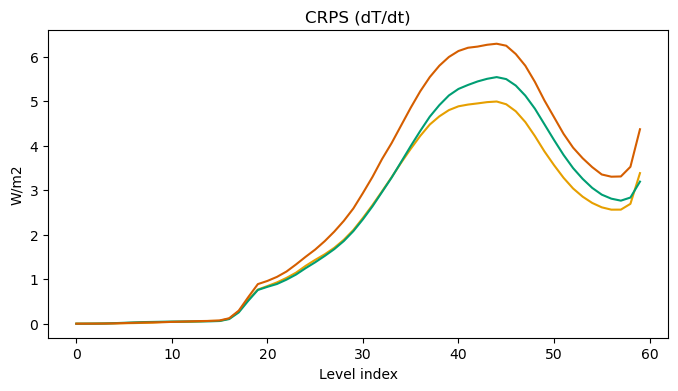

In [12]:
plt.figure(figsize=(8, 4)) 
plt.plot(range(60), hsr_ptend_t_CRPS, label='HSR', color = hsr_color)
plt.plot(range(60), rpn_ptend_t_CRPS, label='RPN', color = rpn_color)
plt.plot(range(60), cvae_ptend_t_CRPS, label='cVAE', color = cvae_color)
plt.xlabel('Level index')
plt.ylabel('W/m2')
plt.title('CRPS (dT/dt)')
# plt.legend()

In [13]:
hsr_ptend_t_CRPS

array([2.64452935e-03, 2.62259536e-03, 3.80022113e-03, 4.86215301e-03,
       7.45524467e-03, 1.12186575e-02, 1.48110997e-02, 1.97469571e-02,
       2.56030249e-02, 3.79131149e-02, 4.16331403e-02, 4.21578507e-02,
       4.49252704e-02, 5.25611830e-02, 6.44821604e-02, 6.40285799e-02,
       1.15790195e-01, 2.78318768e-01, 5.40925068e-01, 7.68572293e-01,
       8.46902240e-01, 9.29146575e-01, 1.03093596e+00, 1.14888729e+00,
       1.30091135e+00, 1.43560211e+00, 1.56100070e+00, 1.70676086e+00,
       1.88747335e+00, 2.10736974e+00, 2.37875430e+00, 2.66745272e+00,
       2.97644476e+00, 3.29229892e+00, 3.61910917e+00, 3.92998254e+00,
       4.22204569e+00, 4.47800955e+00, 4.66151217e+00, 4.80172402e+00,
       4.88693905e+00, 4.92602307e+00, 4.95234906e+00, 4.98099050e+00,
       4.99478430e+00, 4.93281328e+00, 4.77531842e+00, 4.53262090e+00,
       4.21879157e+00, 3.87347592e+00, 3.56581612e+00, 3.28067996e+00,
       3.04011914e+00, 2.85616712e+00, 2.71504728e+00, 2.61665419e+00,
      

In [14]:
rpn_ptend_t_CRPS

array([8.09964351e-04, 1.94716185e-03, 3.45817254e-03, 6.54526780e-03,
       1.37499075e-02, 2.17844239e-02, 3.12240854e-02, 3.77118824e-02,
       4.12006289e-02, 4.54857911e-02, 4.94234480e-02, 5.10133683e-02,
       5.20660057e-02, 5.26658885e-02, 5.43752132e-02, 6.18095680e-02,
       1.05158905e-01, 2.54482834e-01, 5.17439077e-01, 7.59229387e-01,
       8.29922268e-01, 8.93504699e-01, 9.91376195e-01, 1.10632890e+00,
       1.24901516e+00, 1.38096908e+00, 1.52380101e+00, 1.67711088e+00,
       1.85900792e+00, 2.08165654e+00, 2.34792719e+00, 2.63909608e+00,
       2.96056568e+00, 3.28343686e+00, 3.63642409e+00, 3.99187348e+00,
       4.33325467e+00, 4.65474340e+00, 4.91395158e+00, 5.13129435e+00,
       5.27743743e+00, 5.36710211e+00, 5.44562990e+00, 5.50487780e+00,
       5.54348760e+00, 5.49845180e+00, 5.35335941e+00, 5.12674556e+00,
       4.83402520e+00, 4.48294656e+00, 4.13121992e+00, 3.79465017e+00,
       3.49792496e+00, 3.25633417e+00, 3.05329123e+00, 2.90173964e+00,
      

In [15]:
cvae_ptend_t_CRPS

array([8.73251791e-04, 1.82944418e-03, 2.59602388e-03, 4.98618027e-03,
       9.27286520e-03, 1.54885789e-02, 2.16360736e-02, 2.78262043e-02,
       3.11512068e-02, 3.56638606e-02, 4.15719036e-02, 4.81151372e-02,
       5.48963976e-02, 6.06409983e-02, 6.40892402e-02, 7.46607576e-02,
       1.23532845e-01, 2.94368780e-01, 5.99660039e-01, 8.91111511e-01,
       9.62408267e-01, 1.05344993e+00, 1.17383893e+00, 1.33361987e+00,
       1.50452877e+00, 1.66700591e+00, 1.85627993e+00, 2.07086629e+00,
       2.31267073e+00, 2.59162985e+00, 2.93833552e+00, 3.30010166e+00,
       3.70140378e+00, 4.05909270e+00, 4.45709469e+00, 4.85383785e+00,
       5.22464445e+00, 5.54421089e+00, 5.79971407e+00, 5.99600738e+00,
       6.13013040e+00, 6.20302929e+00, 6.22904537e+00, 6.26992189e+00,
       6.29354662e+00, 6.24879344e+00, 6.06184758e+00, 5.79858610e+00,
       5.43666272e+00, 5.01841036e+00, 4.64440306e+00, 4.26873462e+00,
       3.95764705e+00, 3.72004347e+00, 3.52004583e+00, 3.35474043e+00,
      

Text(0.5, 1.0, 'CRPS (dq/dt)')

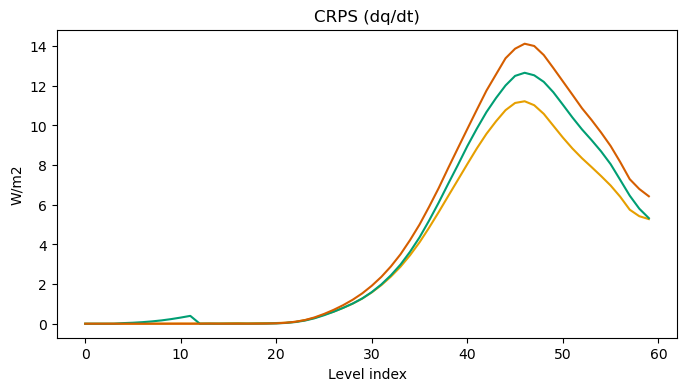

In [16]:
plt.figure(figsize=(8, 4)) 
plt.plot(range(60), hsr_ptend_q0001_CRPS, label = 'HSR', color = hsr_color)
plt.plot(range(60), rpn_ptend_q0001_CRPS, label = 'RPN', color = rpn_color)
plt.plot(range(60), cvae_ptend_q0001_CRPS, label = 'cVAE', color = cvae_color)
plt.xlabel('Level index')
plt.ylabel('W/m2')
plt.title('CRPS (dq/dt)')
# plt.legend()

In [17]:
hsr_ptend_q0001_CRPS

array([5.91876853e-05, 1.04959436e-04, 1.68845968e-04, 1.74949440e-03,
       6.81680016e-04, 9.91993158e-04, 1.71901841e-03, 3.26753244e-03,
       3.58093021e-03, 5.59118996e-03, 7.91893069e-03, 5.15031182e-03,
       1.31706706e-02, 1.54653721e-02, 1.31548503e-02, 2.12900722e-02,
       2.67473831e-02, 1.68643820e-02, 2.60039708e-02, 2.96670790e-02,
       3.46873626e-02, 5.27539712e-02, 9.63887427e-02, 1.81258559e-01,
       2.91777641e-01, 4.55155273e-01, 6.05374931e-01, 7.98121883e-01,
       1.01309153e+00, 1.27143289e+00, 1.58108658e+00, 1.94682603e+00,
       2.37836475e+00, 2.87280540e+00, 3.45209550e+00, 4.10820473e+00,
       4.84679373e+00, 5.62947681e+00, 6.44143740e+00, 7.24594675e+00,
       8.05400953e+00, 8.84623452e+00, 9.57766476e+00, 1.02086921e+01,
       1.07734240e+01, 1.11358787e+01, 1.12212589e+01, 1.10221591e+01,
       1.05864436e+01, 9.98777575e+00, 9.39087405e+00, 8.83900577e+00,
       8.34792147e+00, 7.90393833e+00, 7.44943612e+00, 6.97091981e+00,
      

In [18]:
rpn_ptend_q0001_CRPS

array([3.40730596e-10, 5.61185885e-10, 6.45184232e-10, 3.71230677e-10,
       3.14881271e-02, 5.02170995e-02, 7.91551132e-02, 1.18017579e-01,
       1.68248735e-01, 2.33405164e-01, 3.10370405e-01, 3.96284437e-01,
       1.01036175e-05, 1.60295806e-05, 5.04251994e-05, 2.55841947e-04,
       4.79451226e-04, 8.82631098e-04, 2.04812778e-03, 6.13299709e-03,
       1.68607408e-02, 3.93416906e-02, 8.44382965e-02, 1.58559831e-01,
       2.74708498e-01, 4.28071054e-01, 6.05209989e-01, 8.00583888e-01,
       1.01809612e+00, 1.27330493e+00, 1.59577652e+00, 1.98336223e+00,
       2.44371024e+00, 2.98081634e+00, 3.62782334e+00, 4.35832239e+00,
       5.20564538e+00, 6.10774489e+00, 7.06134747e+00, 7.99619094e+00,
       8.96011807e+00, 9.84402778e+00, 1.06749944e+01, 1.13822753e+01,
       1.20188274e+01, 1.25013864e+01, 1.26585143e+01, 1.25310623e+01,
       1.22009955e+01, 1.16785519e+01, 1.10468428e+01, 1.04040428e+01,
       9.80328542e+00, 9.26384797e+00, 8.69389060e+00, 8.04823983e+00,
      

In [19]:
cvae_ptend_q0001_CRPS

array([2.38887855e-06, 8.54347880e-07, 3.17527340e-06, 3.57854577e-06,
       1.80049206e-03, 7.45940442e-06, 1.29068954e-05, 1.53249336e-05,
       6.16248936e-05, 7.07374324e-05, 9.31743853e-05, 4.90586105e-04,
       1.29350923e-04, 4.30518152e-03, 1.65271882e-04, 3.16288283e-04,
       7.09750531e-04, 1.27209939e-03, 2.66572413e-03, 7.76113908e-03,
       2.03678923e-02, 4.74471816e-02, 9.83229162e-02, 1.83063393e-01,
       3.17926972e-01, 4.92780541e-01, 6.99577139e-01, 9.36043123e-01,
       1.20982773e+00, 1.53156909e+00, 1.91679350e+00, 2.36387001e+00,
       2.89090582e+00, 3.49966088e+00, 4.21652028e+00, 5.00510359e+00,
       5.90094702e+00, 6.84137350e+00, 7.85464920e+00, 8.84301222e+00,
       9.82413787e+00, 1.07975745e+01, 1.17560773e+01, 1.25744629e+01,
       1.33906258e+01, 1.38730797e+01, 1.41238527e+01, 1.40093977e+01,
       1.35530910e+01, 1.28991969e+01, 1.22253231e+01, 1.15516052e+01,
       1.08704487e+01, 1.02788397e+01, 9.64517617e+00, 8.96440076e+00,
      

In [20]:
print("CRPS for HSR")
print('ptend_t')
print(np.mean(hsr_ptend_t_CRPS))
print('ptend_q0001')
print(np.mean(hsr_ptend_q0001_CRPS))
print('netsw')
print(hsr_netsw_CRPS)
print('flwds')
print(hsr_flwds_CRPS)
print('precsc')
print(hsr_precsc_CRPS)
print('precc')
print(hsr_precc_CRPS)
print('sols')
print(hsr_sols_CRPS)
print('soll')
print(hsr_soll_CRPS)
print('solsd')
print(hsr_solsd_CRPS)
print('solld')
print(hsr_solld_CRPS)

CRPS for HSR
ptend_t
2.1580774343531792
ptend_q0001
3.6445144552173825
netsw
14.620414442990606
flwds
4.560824417480576
precsc
2.9048409310019667
precc
34.297920290994476
sols
8.369402740664123
soll
10.138460986732461
solsd
4.773135360907154
solld
4.598501530273872


In [21]:
print("CRPS for RPN")
print('ptend_t')
print(np.mean(rpn_ptend_t_CRPS))
print('ptend_q0001')
print(np.mean(rpn_ptend_q0001_CRPS))
print('netsw')
print(rpn_netsw_CRPS)
print('flwds')
print(rpn_flwds_CRPS)
print('precsc')
print(rpn_precsc_CRPS)
print('precc')
print(rpn_precc_CRPS)
print('sols')
print(rpn_sols_CRPS)
print('soll')
print(rpn_soll_CRPS)
print('solsd')
print(rpn_solsd_CRPS)
print('solld')
print(rpn_solld_CRPS)

CRPS for RPN
ptend_t
2.3054146410932317
ptend_q0001
4.10023245444231
netsw
14.817277832474153
flwds
4.430497646630767
precsc
2.7289959221787274
precc
30.08300604728733
sols
8.30868859878903
soll
10.4874380675445
solsd
4.649343743252384
solld
4.682123812871824


In [22]:
print("CRPS for cVAE")
print('ptend_t')
print(np.mean(cvae_ptend_t_CRPS))
print('ptend_q0001')
print(np.mean(cvae_ptend_q0001_CRPS))
print('netsw')
print(cvae_netsw_CRPS)
print('flwds')
print(cvae_flwds_CRPS)
print('precsc')
print(cvae_precsc_CRPS)
print('precc')
print(cvae_precc_CRPS)
print('sols')
print(cvae_sols_CRPS)
print('soll')
print(cvae_soll_CRPS)
print('solsd')
print(cvae_solsd_CRPS)
print('solld')
print(cvae_solld_CRPS)

CRPS for cVAE
ptend_t
2.707906789582796
ptend_q0001
4.56500945022936
netsw
20.529120573006654
flwds
6.732408880589889
precsc
3.5132942979190234
precc
40.16616853117693
sols
11.90870472223168
soll
14.42338355955961
solsd
5.944789868900808
solld
5.9253716615661745


In [23]:
# Define the categories and number of model groups
categories = ['dT/dt', 'dq/dt', 'NETSW', 'FLWDS', 'PRECSC', 'PRECC', 'SOLS', 'SOLL', 'SOLSD', 'SOLLD']
num_groups = 3
colors = [hsr_color, rpn_color, cvae_color]
values = np.zeros((num_groups, len(categories)))

values[0,0] = np.mean(hsr_ptend_t_CRPS)
values[1,0] = np.mean(rpn_ptend_t_CRPS)
values[2,0] = np.mean(cvae_ptend_t_CRPS)

values[0,1] = np.mean(hsr_ptend_q0001_CRPS)
values[1,1] = np.mean(rpn_ptend_q0001_CRPS)
values[2,1] = np.mean(cvae_ptend_q0001_CRPS)

values[0,2] = hsr_netsw_CRPS
values[1,2] = rpn_netsw_CRPS
values[2,2] = cvae_netsw_CRPS

values[0,3] = hsr_flwds_CRPS
values[1,3] = rpn_flwds_CRPS
values[2,3] = cvae_flwds_CRPS

values[0,4] = hsr_precsc_CRPS
values[1,4] = rpn_precsc_CRPS
values[2,4] = cvae_precsc_CRPS

values[0,5] = hsr_precc_CRPS
values[1,5] = rpn_precc_CRPS
values[2,5] = cvae_precc_CRPS

values[0,6] = hsr_sols_CRPS
values[1,6] = rpn_sols_CRPS
values[2,6] = cvae_sols_CRPS

values[0,7] = hsr_soll_CRPS
values[1,7] = rpn_soll_CRPS
values[2,7] = cvae_soll_CRPS

values[0,8] = hsr_solsd_CRPS
values[1,8] = rpn_solsd_CRPS
values[2,8] = cvae_solsd_CRPS

values[0,9] = hsr_solld_CRPS
values[1,9] = rpn_solld_CRPS
values[2,9] = cvae_solld_CRPS

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or weight: {a

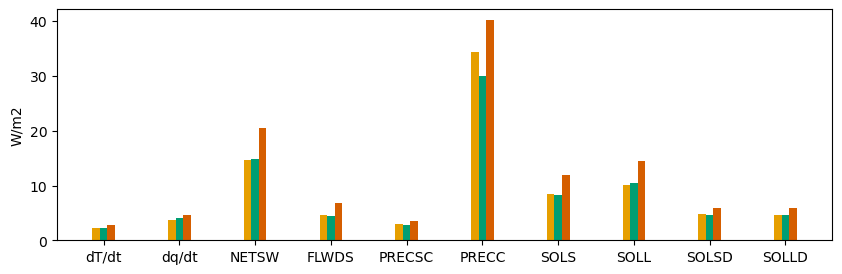

(None, './crps_bar_plot_corrected.png')

In [24]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 3))

pos = np.arange(len(categories))
width = 0.1  # the width of the bars

# Plot the bars for each model group
for i in range(num_groups):
    ax.bar(pos + i * width, values[i], width, label=f'Model {i+1}', color=colors[i])

# Set the y-axis to log scale
# ax.set_yscale('log')

# Set the axis labels and title
ax.set_ylabel('W/m2')

# Set the x-axis category labels
ax.set_xticks(pos + width * (num_groups - 1) / 2)
ax.set_xticklabels(categories)

# Add a legend
# ax.legend()

# Rotate the tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_xticklabels())

# Save the recreated plot to a file
recreated_plot_path = './crps_bar_plot_corrected.png'
# plt.savefig(recreated_plot_path)
plt.show(), recreated_plot_path

In [28]:
!pwd

/ocean/projects/atm200007p/jlin96/neurips_proj/crps_ingredients
